In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scvi
import math
from glob import glob
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

Global seed set to 0


In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.7.8 umap==0.5.2 numpy==1.21.5 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


In [3]:
adata = sc.read_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass/cellid_annotated.h5ad")

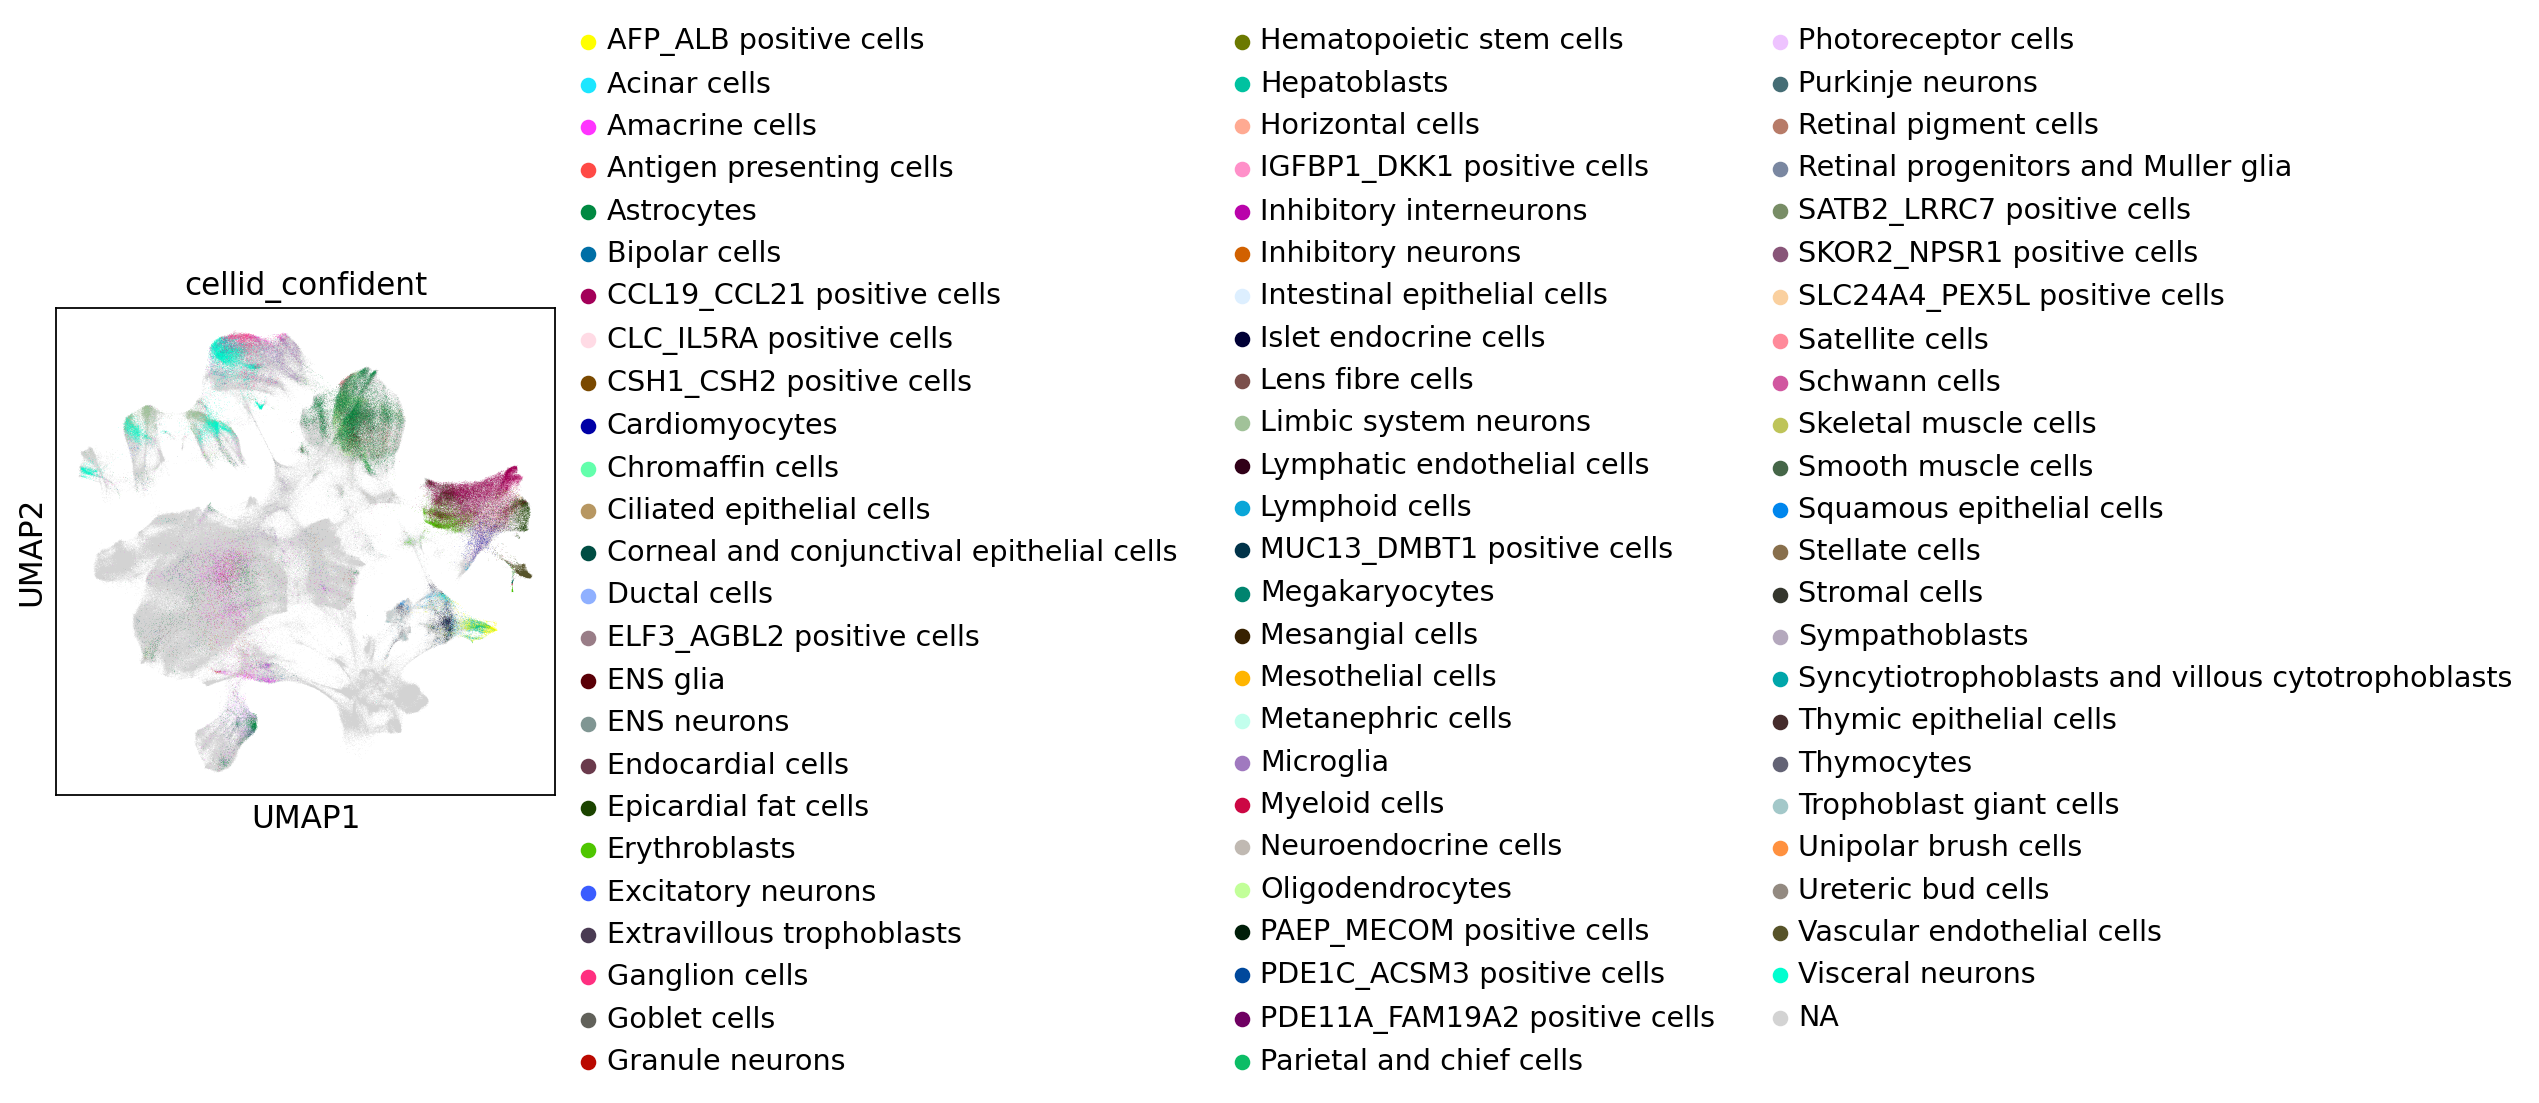

In [4]:
sc.pl.umap(adata, color="cellid_confident")

## Sample Summary

How many cells we have for each individual in each cell type?

In [5]:
cell_counts = adata.obs[['cellid_confident', 'donor_id_x']]
cell_counts = cell_counts[~cell_counts['cellid_confident'].isnull()]
cell_counts = pd.DataFrame(cell_counts.groupby('cellid_confident').value_counts()).reset_index(inplace=False).rename(columns={0: "n_cells"})
cell_counts

,cellid_confident,donor_id_x,n_cells
0,AFP_ALB positive cells,NA18862,354
1,AFP_ALB positive cells,NA19144,259
2,AFP_ALB positive cells,NA18912,172
3,AFP_ALB positive cells,NA18856,152
4,AFP_ALB positive cells,NA18486,150
...,...,...,...
3718,Visceral neurons,NA18913,27
3719,Visceral neurons,NA19108,16
3720,Visceral neurons,NA19203,4
3721,Visceral neurons,NA18498,1


To get this into proper form, we need to:
- Reformat cell types
- Add a column of nUMIs per sample (we don't need these for this analysis so we'll leave it as NaN for now)

In [6]:
cell_counts['type'] = [s.replace(" ", "-").replace("_", "-") for s in cell_counts['cellid_confident']]
cell_counts['individual'] = [s.replace("NA", "") for s in cell_counts['donor_id_x']]
cell_counts['n_umi'] = np.nan
cell_counts['ind_type'] = cell_counts['individual'].astype(str) + "_" + cell_counts['type'].astype(str)
cell_counts = cell_counts[['ind_type', 'n_umi', 'individual', 'type', 'n_cells']]
cell_counts

,ind_type,n_umi,individual,type,n_cells
0,18862_AFP-ALB-positive-cells,NaN,18862,AFP-ALB-positive-cells,354
1,19144_AFP-ALB-positive-cells,NaN,19144,AFP-ALB-positive-cells,259
2,18912_AFP-ALB-positive-cells,NaN,18912,AFP-ALB-positive-cells,172
3,18856_AFP-ALB-positive-cells,NaN,18856,AFP-ALB-positive-cells,152
4,18486_AFP-ALB-positive-cells,NaN,18486,AFP-ALB-positive-cells,150
...,...,...,...,...,...
3718,18913_Visceral-neurons,NaN,18913,Visceral-neurons,27
3719,19108_Visceral-neurons,NaN,19108,Visceral-neurons,16
3720,19203_Visceral-neurons,NaN,19203,Visceral-neurons,4
3721,18498_Visceral-neurons,NaN,18498,Visceral-neurons,1


We'll drop any samples with less than 5 cells

In [7]:
cell_counts['dropped'] = cell_counts['n_cells'] < 5
cell_counts.to_csv("/project2/gilad/jpopp/ebQTL/data/static/highpass_cellid_confident/pseudobulk-scran/sample_summary.tsv",
                  sep="\t", index=False)

/tmp/jobs/19548317/ipykernel_62722/3230909781.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_counts['dropped'] = cell_counts['n_cells'] < 5


## Cell Type Summary

We will filter to samples with at least 5 cells, and cell types with over 25 individuals represented.

In [8]:
ind_counts = cell_counts[cell_counts['n_cells'] >= 5]
ind_counts = pd.DataFrame(ind_counts[['type']].value_counts()).reset_index(inplace=False).rename(columns={0: "n"})
ind_counts = ind_counts[ind_counts['n']>25]
ind_counts

,type,n
0,Astrocytes,51
1,Visceral-neurons,48
2,Amacrine-cells,48
3,Oligodendrocytes,47
4,Ganglion-cells,46
5,Smooth-muscle-cells,46
6,Limbic-system-neurons,45
7,Vascular-endothelial-cells,44
8,Photoreceptor-cells,44
9,CCL19-CCL21-positive-cells,43


In [23]:
list(ind_counts['type'])

['Astrocytes',
 'Visceral-neurons',
 'Amacrine-cells',
 'Oligodendrocytes',
 'Ganglion-cells',
 'Smooth-muscle-cells',
 'Limbic-system-neurons',
 'Vascular-endothelial-cells',
 'Photoreceptor-cells',
 'CCL19-CCL21-positive-cells',
 'CLC-IL5RA-positive-cells',
 'Mesangial-cells',
 'AFP-ALB-positive-cells',
 'Bipolar-cells',
 'Satellite-cells',
 'ENS-neurons',
 'ENS-glia',
 'Granule-neurons',
 'Hepatoblasts',
 'Microglia',
 'IGFBP1-DKK1-positive-cells',
 'Purkinje-neurons',
 'Epicardial-fat-cells',
 'Cardiomyocytes']

In [9]:
ind_counts.to_csv("/project2/gilad/jpopp/ebQTL/data/static/highpass_cellid_confident/pseudobulk-scran/samples_per_celltype.tsv",
                  sep="\t", index=False)

## Pseudobulk Aggregation

First, we can highlight which samples will be kept for QTL analysis

In [10]:
cell_types_inc = ind_counts['type']

In [11]:
samples_inc = cell_counts[(cell_counts['dropped'] == False) & (cell_counts['type'].isin(cell_types_inc))]['ind_type']
samples_inc

0       18862_AFP-ALB-positive-cells
1       19144_AFP-ALB-positive-cells
2       18912_AFP-ALB-positive-cells
3       18856_AFP-ALB-positive-cells
4       18486_AFP-ALB-positive-cells
                    ...             
3715          19257_Visceral-neurons
3716          19152_Visceral-neurons
3717          19128_Visceral-neurons
3718          18913_Visceral-neurons
3719          19108_Visceral-neurons
Name: ind_type, Length: 953, dtype: object

In [12]:
cell_subset = adata.obs[['cellid_confident', 'donor_id_x']]
cell_subset['type'] = [s.replace(" ", "-").replace("_", "-") for s in cell_subset['cellid_confident'].astype(str)]
cell_subset['ind'] = [s.replace("NA", "") for s in cell_subset['donor_id_x'].astype(str)]
cell_subset['sample'] = cell_subset['ind'] + "_" + cell_subset['type']
cell_subset = cell_subset[cell_subset['sample'].isin(samples_inc)]
cell_subset

/tmp/jobs/19548317/ipykernel_62722/915340806.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_subset['type'] = [s.replace(" ", "-").replace("_", "-") for s in cell_subset['cellid_confident'].astype(str)]
/tmp/jobs/19548317/ipykernel_62722/915340806.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_subset['ind'] = [s.replace("NA", "") for s in cell_subset['donor_id_x'].astype(str)]
/tmp/jobs/19548317/ipykernel_62722/915340806.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy

,cellid_confident,donor_id_x,type,ind,sample
cell,,,,,
CCACTTGGTACGTAGG-82,Astrocytes,NA19127,Astrocytes,19127,19127_Astrocytes
AGAGAGCCAGCAGGAT-64,Microglia,NA18508,Microglia,18508,18508_Microglia
GGGTTATTCGAAGCCC-39,CLC_IL5RA positive cells,NA18522,CLC-IL5RA-positive-cells,18522,18522_CLC-IL5RA-positive-cells
TGCGGCAAGGTTGCCC-27,Astrocytes,NA19159,Astrocytes,19159,19159_Astrocytes
ATACCGACAAGCGGAT-77,CCL19_CCL21 positive cells,NA18508,CCL19-CCL21-positive-cells,18508,18508_CCL19-CCL21-positive-cells
...,...,...,...,...,...
GAGTTTGTCTCCAATT-85,Astrocytes,NA19130,Astrocytes,19130,19130_Astrocytes
CCTTGTGAGGCTGAAC-26,CLC_IL5RA positive cells,NA18912,CLC-IL5RA-positive-cells,18912,18912_CLC-IL5RA-positive-cells
TGTGTGACAGCACAGA-83,Visceral neurons,NA18486,Visceral-neurons,18486,18486_Visceral-neurons


For pseudobulk aggregation, we're going to use the scran-normalized data

In [13]:
scran_adata = sc.read_h5ad("/project2/gilad/ktayeb/ebqtl-workflowr/output/proc/EB_high_pass_filtered_normalized.h5ad")

In [14]:
scran_adata = scran_adata[cell_subset.index]

In [15]:
scran_adata

View of AnnData object with n_obs × n_vars = 132381 × 35324
    obs: 'sample_id', 'Collection.Date', 'Lane', 'Sample.ID', 'cDNA.amp.cycles', 'cDNA.total.yield', 'library.prep.batch', 'Sequencing.batch', 'col.group', 'donor_id', 'prob_max', 'prob_doublet', 'n_vars', 'best_singlet', 'best_doublet', 'doublet_logLikRatio', 'Line.True', 'Line.StockLabel', 'contaminated', 'swapped', 'Feeder.passage', 'Feeder.Free.passage', 'sex', 'Formation.replicate', 'collection.replicate', 'formation.date', 'visual.confluence', 'total.cells.per.lane..correct.', 'X..Viable..based.on.average.of.two.counts.', 'days.maintained.in.LD.prior.to.formation', 'who.dissociated.the.lines.for.formation', 'cell.counter.correction', 'comments', 'collection.date', 'collection.group.label', 'EB.appearance.notes', 'dissociated.by.', 'approx..time.in.accumax..in.minutes.', 'leiden_coarse', 'sizeFactor', 'scranGroup', 'scranCluster'
    var: 'gene_ids', 'feature_types'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 

To compute the mean, we're first going to get a one-hot encoding of the sample assignment for each cell

In [16]:
onehot = OneHotEncoder(sparse=True).fit_transform(cell_subset[['sample']])
onehot

<132381x953 sparse matrix of type '<class 'numpy.float64'>'
	with 132381 stored elements in Compressed Sparse Row format>

In [17]:
n_cells = onehot.sum(axis=0)

In [18]:
pseudobulk_sum = scran_adata.X.transpose() * onehot

In [19]:
pseudobulk_mean = pseudobulk_sum / n_cells

In [20]:
pseudobulk_mean = pd.DataFrame(pseudobulk_mean, 
             index=scran_adata.var_names, columns=cell_subset['sample'].astype("category").cat.categories)

In [24]:
pseudobulk_mean.to_csv("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass_cellid_confident.pseudobulk-scran.tsv",
                  sep="\t", index_label="gene")

### Check that pseudobulk aggregation is correct

In [143]:
pseudobulk_mean

,18486_AFP-ALB-positive-cells,18486_Amacrine-cells,18486_Astrocytes,18486_Bipolar-cells,18486_CCL19-CCL21-positive-cells,18486_CLC-IL5RA-positive-cells,18486_ENS-glia,18486_ENS-neurons,18486_Ganglion-cells,18486_Granule-neurons,...,19257_IGFBP1-DKK1-positive-cells,19257_Limbic-system-neurons,19257_Mesangial-cells,19257_Oligodendrocytes,19257_Photoreceptor-cells,19257_Purkinje-neurons,19257_Satellite-cells,19257_Smooth-muscle-cells,19257_Vascular-endothelial-cells,19257_Visceral-neurons
MIR1302-2HG,0.000000,0.000000,0.002429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OR4F5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AL627309.1,0.021397,0.020301,0.005297,0.037972,0.020032,0.019621,0.008813,0.027102,0.007719,0.0,...,0.092248,0.000000,0.000000,0.000000,0.016553,0.000000,0.000000,0.000000,0.007607,0.000000
AL627309.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AL627309.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC136616.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AC023491.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.005068,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AC007325.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AC007325.4,0.065691,0.020232,0.051223,0.013706,0.080316,0.031558,0.036392,0.042928,0.117277,0.0,...,0.091610,0.206415,0.150016,0.054412,0.273054,0.213328,0.111558,0.049105,0.107287,0.279101


In [139]:
test_cells = cell_subset[cell_subset['sample']=="18486_Ganglion-cells"]
test = scran_adata[test_cells.index]
test

View of AnnData object with n_obs × n_vars = 24 × 35324
    obs: 'sample_id', 'Collection.Date', 'Lane', 'Sample.ID', 'cDNA.amp.cycles', 'cDNA.total.yield', 'library.prep.batch', 'Sequencing.batch', 'col.group', 'donor_id', 'prob_max', 'prob_doublet', 'n_vars', 'best_singlet', 'best_doublet', 'doublet_logLikRatio', 'Line.True', 'Line.StockLabel', 'contaminated', 'swapped', 'Feeder.passage', 'Feeder.Free.passage', 'sex', 'Formation.replicate', 'collection.replicate', 'formation.date', 'visual.confluence', 'total.cells.per.lane..correct.', 'X..Viable..based.on.average.of.two.counts.', 'days.maintained.in.LD.prior.to.formation', 'who.dissociated.the.lines.for.formation', 'cell.counter.correction', 'comments', 'collection.date', 'collection.group.label', 'EB.appearance.notes', 'dissociated.by.', 'approx..time.in.accumax..in.minutes.', 'leiden_coarse', 'sizeFactor', 'scranGroup', 'scranCluster'
    var: 'gene_ids', 'feature_types'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_p

In [140]:
list(test.var_names).index("AC007325.4")

35322

In [141]:
np.mean(test.X[:,35322])

0.11727682